# INSTALL KAGGLE PACKAGE TO LOAD IMAGES DIRECTLY

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vagadro","key":"2dad87d4674deb719c3e3e6d1dc6431a"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# DOWNLOAD STATE FARM DISTRACTED DRIVER DATASET FOR KAGGLE

In [7]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:26<00:00, 156MB/s]
100% 4.00G/4.00G [00:26<00:00, 159MB/s]


In [8]:
! unzip state-farm-distracted-driver-detection

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

since data has been downloaded we will start preprocessing and building models 

# LOAD PACKAGES

In [9]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import dask.bag as db
from dask import diagnostics
from PIL import Image
from PIL import Image
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.layers import Input,Lambda, Dense,Flatten,Activation,Dropout,MaxPooling2D,Conv2D
import tensorflow as tf
from keras.models import Sequential
from glob import glob
from keras import backend as K

In [10]:
train_path="/content/imgs/train"
test_path="/content/imgs/test"

check random image to see if data is loading correctly


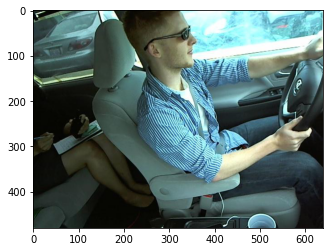

In [11]:
img=load_img("/content/imgs/train/c0/img_100026.jpg")
plt.imshow(img)
plt.axis('on')
plt.show()

# EDA 

## CHECK FOR COUNT OF IMAGES IN EACH CLASS

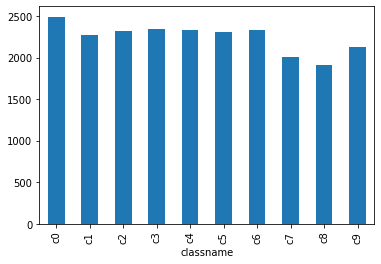

In [12]:
df=pd.read_csv('/content/driver_imgs_list.csv')   # all info about class is present in the csv file. We will use that
grp=df.groupby('classname')['classname'].count()
grp.plot(kind='bar')    # plot a bar graph to visualize count of each images in each class

what we note from above plot is that the number of images in each class is not same, but the imbalance is not so great. 
Thus, for now we will keep it like this and proceed ahead. 
We may look at balancing the same in case the model doesnt perform well with test datasets. 

## CEHCK IMAGE DIMENSIONS

Although from the images in the folder we checked random images and found the dimensions to be 640 X 480, but it is better to check it for all the folders(classes) to be sure. 
We used this beatifule code written by Medium Writer Dana Rausch. 
https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

In [13]:
directories = {'c0': '/content/imgs/train/c0/',
              'c1': '/content/imgs/train/c1/',
              'c2': '/content/imgs/train/c2/',
              'c3': '/content/imgs/train/c3/',
              'c4': '/content/imgs/train/c4/',
              'c5': '/content/imgs/train/c5/',
              'c6': '/content/imgs/train/c6/',
              'c7': '/content/imgs/train/c7/',
              'c8': '/content/imgs/train/c8/',
              'c9': '/content/imgs/train/c9/'
              }

def get_dims(file):
  '''Returns dimenstions for an RBG image'''
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

[########################################] | 100% Completed | 10.6s
[########################################] | 100% Completed |  9.2s
[########################################] | 100% Completed | 11.0s
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  9.2s
[########################################] | 100% Completed |  9.3s
[########################################] | 100% Completed |  8.2s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  8.7s


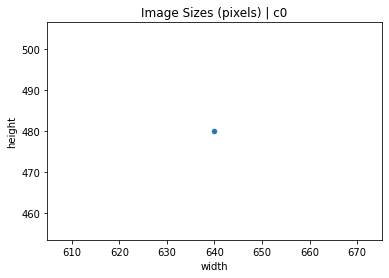

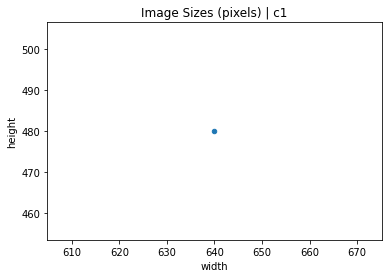

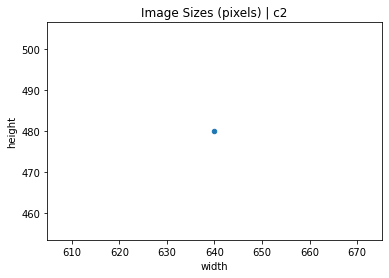

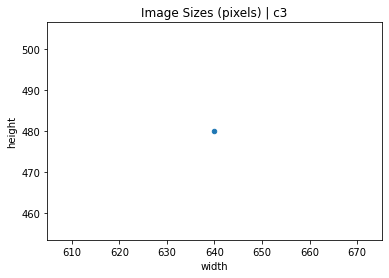

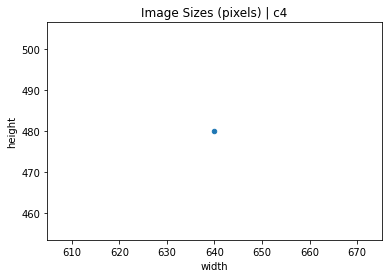

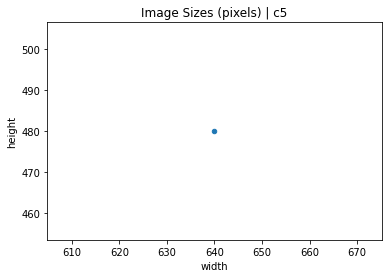

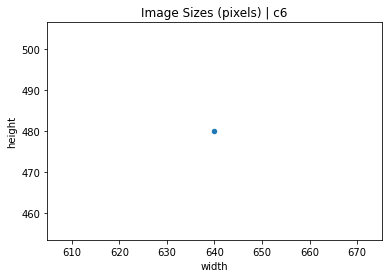

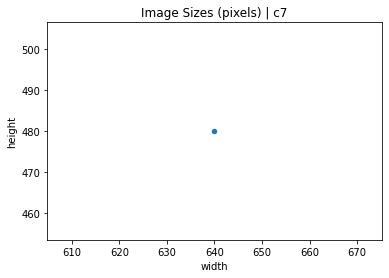

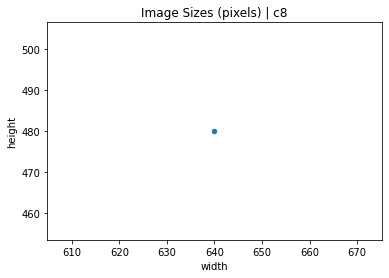

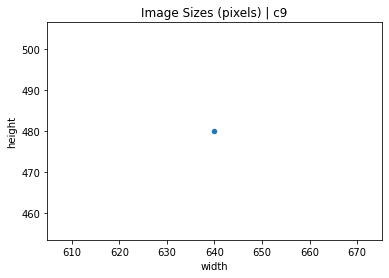

In [ ]:
for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = db.from_sequence(filelist).map(get_dims)
  with diagnostics.ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

# IMAGE AUGMENTATION1- VARIOUS AUGMENTATION TECHNIQUES

In [1]:
img_height, img_width = 224, 224
batch_size=40

In [2]:
# this code is used to see what some random samples post applying image augmentations
# code taken from tensorflow's github article on Dog Vs Cat dataset

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### 1) Image Rotation

In [ ]:
aug_rot = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_rot = aug_rot.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

Found 22424 images belonging to 10 classes.


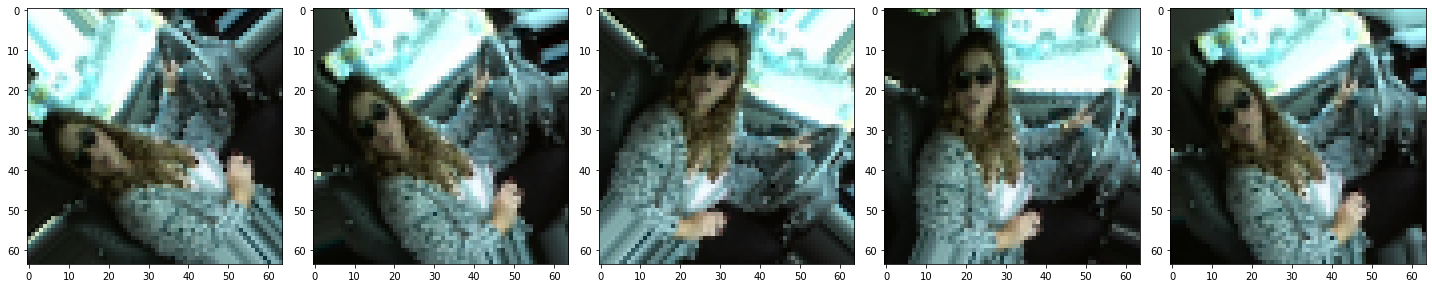

In [ ]:
augmented_images = [train_data_rot[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 2) Image Width/Height Shift

In [ ]:
aug_shift = ImageDataGenerator(rescale=1./255, width_shift_range=0.2,height_shift_range=0.2)

train_data_shift = aug_shift.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

Found 22424 images belonging to 10 classes.


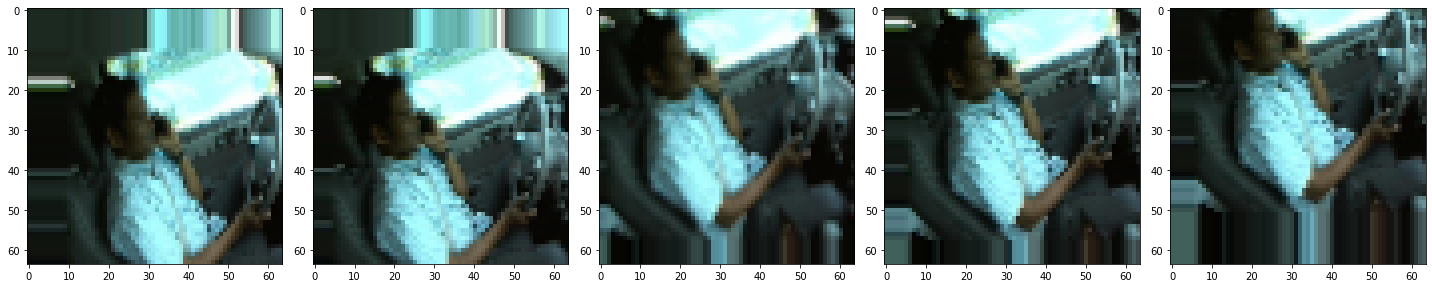

In [ ]:
augmented_images = [train_data_shift[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 3) Zoom Range

Found 22424 images belonging to 10 classes.


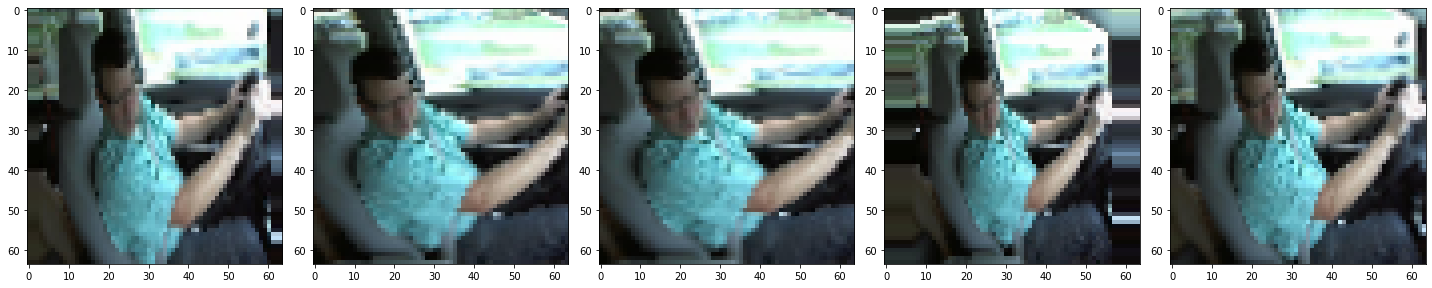

In [ ]:
aug_zoom = ImageDataGenerator(rescale=1./255, zoom_range=0.3)

train_data_zoom = aug_zoom.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_zoom[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 4) Horizontal Flip

Found 22424 images belonging to 10 classes.


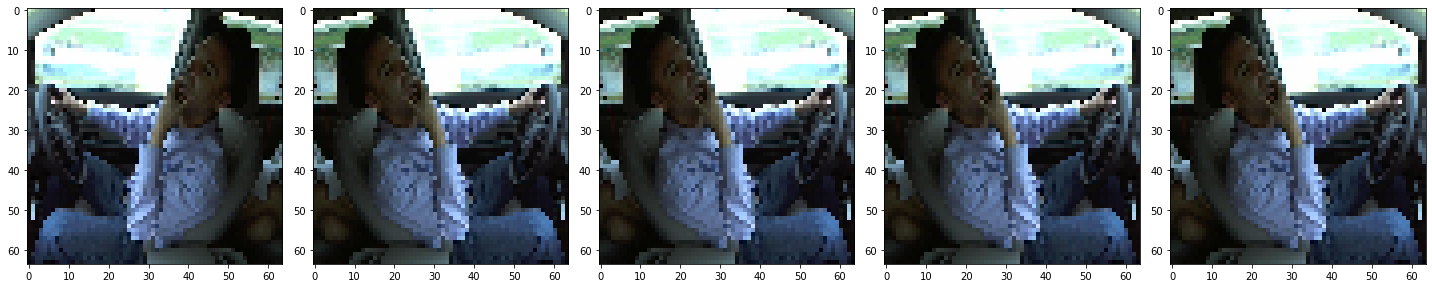

In [ ]:
aug_hflip= ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_hflip = aug_hflip.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_hflip[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 5) Vertical Flip

Found 22424 images belonging to 10 classes.


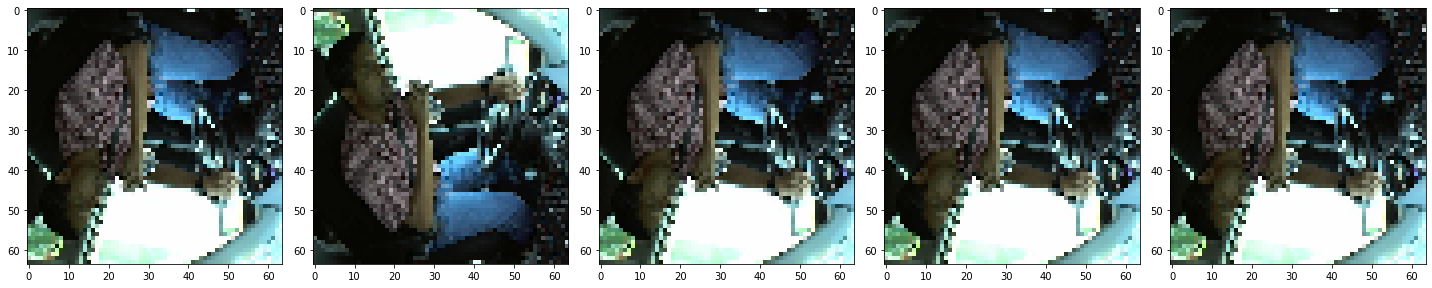

In [ ]:
aug_vflip= ImageDataGenerator(rescale=1./255, vertical_flip=True)

train_data_vflip = aug_vflip.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_vflip[0][0][0] for i in range(5)]
plotImages(augmented_images)

### 6) Brightness Level

Found 22424 images belonging to 10 classes.


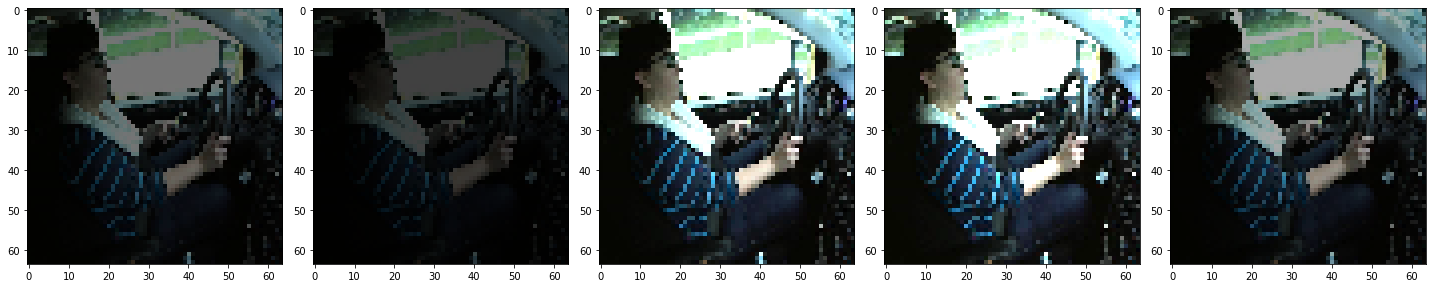

In [ ]:
aug_bright= ImageDataGenerator(rescale=1./255, brightness_range=[0.2,1.5])

train_data_bright = aug_bright.flow_from_directory(batch_size=batch_size,
                                               directory=train_path,
                                               shuffle=True,
                                               target_size=(img_height, img_width))

augmented_images = [train_data_bright[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Combining All Augmentation technique to create train Dataset

In [14]:
# Image Datagen 1

img_height, img_width = 224, 224
batch_size=40

datagen1 = ImageDataGenerator(
    preprocessing_function = lambda x: x.astype('float32')/255 - 0.5, 
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.5],
    fill_mode='nearest')

train_datagen1 = datagen1.flow_from_directory(
    train_path, target_size=(img_height, img_width), 
    batch_size=batch_size, class_mode='categorical', subset='training')

validation_datagen1 = datagen1.flow_from_directory(
    train_path, target_size=(img_height, img_width), 
    batch_size=batch_size, class_mode='categorical', subset='validation')


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


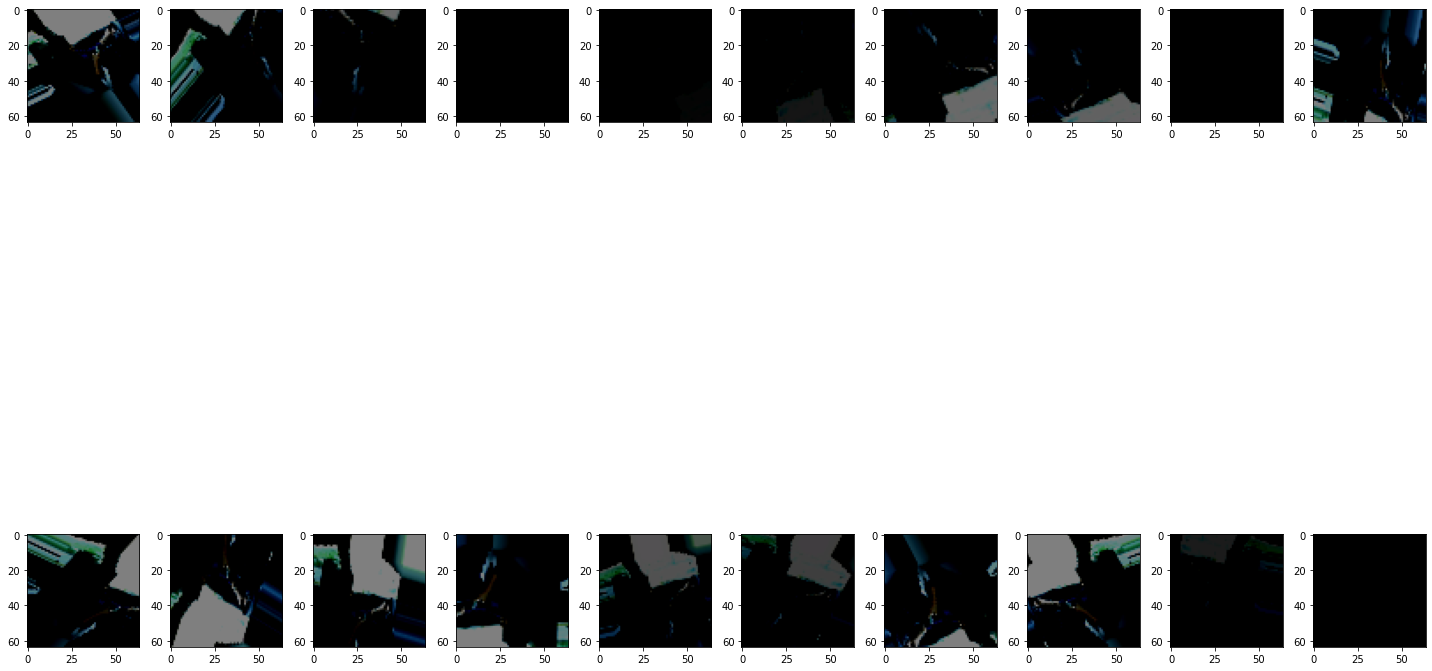

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_datagen1[0][0][0] for i in range(20)]
plotImages(augmented_images)

# IMAGE AUGMENTATION2- IMAGE RESIZING ONLY

In [15]:
# Image Datagen 2- Named as "SIMPLE DATAGEN"

img_height, img_width = 224, 224
batch_size=40

datagen2 = ImageDataGenerator(
    preprocessing_function = lambda x: x.astype('float32')/255 - 0.5, 
    validation_split=0.2)

train_datagen_simple = datagen2.flow_from_directory(
    train_path, target_size=(img_height, img_width), 
    batch_size=batch_size, class_mode='categorical', subset='training')

validation_datagen_simple = datagen2.flow_from_directory(
    train_path, target_size=(img_height, img_width), 
    batch_size=batch_size, class_mode='categorical', subset='validation')


if K.image_data_format()=='channels_first':
  input_shape=(3,img_width,img_height)

else:
  input_shape=(img_width,img_height,3)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


# MODEL3 - TRANSFER LEARNING WITH VGG on DATAGEN 1

In [16]:
# load pre trained VGG16 trained on 'imagenet' dataset without the top layer

vgg16=VGG16(input_shape=[img_height,img_width] + [3],weights='imagenet',include_top=False) 

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
for layer in vgg16.layers:
  layer.trainable=False   

x=Flatten()(vgg16.output)

# add dense layer with output classess equal to classes in the folder

predictions=Dense(10,activation='softmax')(x)

#create a model object
model3=Model(inputs=vgg16.inputs,outputs=predictions)

model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# Compile on Datagen1

model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_history3 = model3.fit(
    x=train_datagen1,
    validation_data=validation_datagen1,
    epochs=15,
    batch_size=batch_size)

Epoch 1/15
449/449 [==============================] - 413s 888ms/step - loss: 3.7511 - accuracy: 0.1820 - val_loss: 2.7338 - val_accuracy: 0.2848
Epoch 2/15
449/449 [==============================] - 395s 881ms/step - loss: 2.9875 - accuracy: 0.2792 - val_loss: 2.3249 - val_accuracy: 0.3586
Epoch 3/15
449/449 [==============================] - 397s 885ms/step - loss: 2.7306 - accuracy: 0.3324 - val_loss: 2.5981 - val_accuracy: 0.3896
Epoch 4/15
449/449 [==============================] - 391s 871ms/step - loss: 2.5718 - accuracy: 0.3687 - val_loss: 2.4014 - val_accuracy: 0.3914
Epoch 5/15
449/449 [==============================] - 393s 874ms/step - loss: 2.4446 - accuracy: 0.3929 - val_loss: 3.3657 - val_accuracy: 0.2845
Epoch 6/15
449/449 [==============================] - 392s 873ms/step - loss: 2.3867 - accuracy: 0.4109 - val_loss: 2.1020 - val_accuracy: 0.4403
Epoch 7/15
449/449 [==============================] - 390s 869ms/step - loss: 2.2599 - accuracy: 0.4345 - val_loss: 2.4068 -

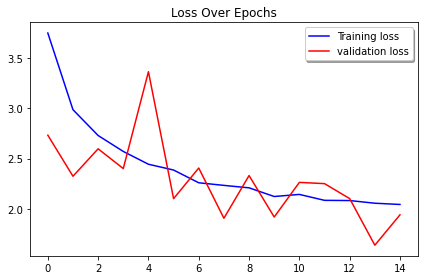

In [19]:
plt.plot(model_history3.history['loss'], color='b', label="Training loss")
plt.plot(model_history3.history['val_loss'], color='r', label="validation loss")
legend = plt.legend(loc='best', shadow=True)
plt.title('Loss Over Epochs')
plt.tight_layout()
plt.show()

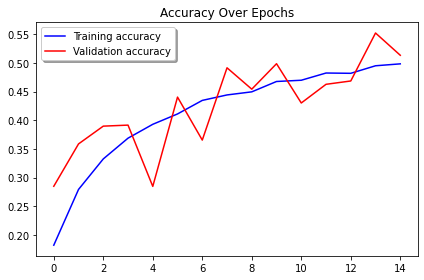

In [20]:
plt.plot(model_history3.history['accuracy'], color='b', label="Training accuracy")
plt.plot(model_history3.history['val_accuracy'], color='r',label="Validation accuracy")
legend = plt.legend(loc='best', shadow=True)
plt.title('Accuracy Over Epochs')
plt.tight_layout()
plt.show()